In [1]:
import sys 
sys.executable

'C:\\ProgramData\\Anaconda3\\python.exe'

In [2]:
import os
import re
import numpy as np
import pandas as pd 
import urllib.request
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm
from konlpy.tag import Okt

import tensorflow as tf
import tensorflow_addons as tfa
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.client import device_lib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [3]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14869057385377215971,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4971491488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11305015520845086027
 physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [5]:
data = pd.read_csv('./data/test_data0422_청와대_수작업.csv', encoding = 'euc-kr')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15996 entries, 0 to 15995
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Text             15996 non-null  object 
 1   Feeling_Saltlux  15996 non-null  int64  
 2   Feeling          12443 non-null  float64
 3   Talking          12377 non-null  float64
 4   book_id          12442 non-null  float64
 5   sentence_id      12377 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 749.9+ KB


In [6]:
data = data.iloc[:,:2]
data['Text'].nunique(), data['Feeling_Saltlux'].nunique()
display(data[data.duplicated()])

,Text,Feeling_Saltlux
54,라고 말했어요,4
143,"*젬지 산아, 젬지 산아, 열리거라*",4
150,"*젬지 산아, 젬지 산아, 닫히거라*",1
172,"*젬지 산아, 젬지 산아, 열리거라*",4
215,라고 그가 말했어요,5
...,...,...
15275,라고 말했지요,4
15322,,6
15753,라고 말했습니다,4
15790,라고 말했습니다,4


<AxesSubplot:>

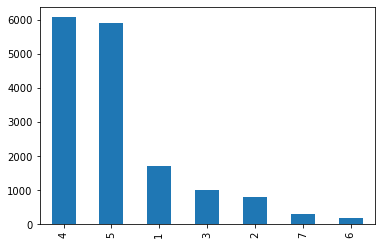

In [7]:
data['Feeling_Saltlux'].value_counts().plot(kind='bar')

In [8]:
#  결측치 제거
data.isnull().sum()
data = data.dropna(how = 'any')
data = data.astype({"Feeling_Saltlux" : 'int64'})
data['Feeling_Saltlux']

0        1
1        2
2        3
3        4
4        5
        ..
15991    4
15992    5
15993    5
15994    4
15995    4
Name: Feeling_Saltlux, Length: 15996, dtype: int64

In [9]:
# 한글만 남기기 
data['Text'] = data['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data

,Text,Feeling_Saltlux
0,인도가 적에게 포위를 당했는데 적들이 은화 백 개를 내놓을 때까지 물러나지 않겠다고...,1
1,그래서 주민들이 북을 치며 선포하길,2
2,누구든 그 돈을 마련하는 사람을 시장으로 삼겠다,3
3,라고 했답니다,4
4,때마침 가난한 어부가 자신의 아들과 호수에서 물고기를 잡아 생활하다 그 적들이 들이...,5
...,...,...
15991,종이 세번 울리자 구렁이는 남편의 복수를 하지 못한 것에 분해 하며 용이 되어 승...,4
15992,구사일생으로 목숨을 건진 선비는 누가 종을 울렸는지 궁금해서 종이 있는 곳으로 가...,5
15993,새끼 까치를 살려준 은혜를 갚기 위해 어미까치는 선비를 살리기 위해 자신의 몸을 ...,5
15994,선비는 은혜를 갚고 죽은 까치들을 거둬 잘 묻어주었습니다,4


In [10]:
train_data = data[2000:]  # train ( 2000 : )  / val ( : 2000)
test_data  = data[:2000]

In [20]:
print(data.iloc[:0])

Empty DataFrame
Columns: [Text, Feeling_Saltlux]
Index: []


In [11]:
data_df.to_csv('GPT2_Test.txt')

In [11]:
train_length  = train_data['Text'].apply(len)

In [12]:
print('문장 길이 최대 값: {}'.format(np.max(train_length)))
print('문장 길이 최소 값: {}'.format(np.min(train_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('문장 길이 중간 값: {}'.format(np.median(train_length)))
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

문장 길이 최대 값: 393
문장 길이 최소 값: 0
문장 길이 평균 값: 32.45
문장 길이 표준편차: 22.60
문장 길이 중간 값: 28.0
문장 길이 제 1 사분위: 16.0
문장 길이 제 3 사분위: 43.0


In [13]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 16
NUM_EPOCHS = 20
#B VALID_SPLIT = 0.2
MAX_LEN = 43 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

In [15]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [16]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["Text"], train_data["Feeling_Saltlux"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|                                                                                        | 0/13996 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Changho_Notebook\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g

# sents: 13996, # labels: 13996


In [17]:
# 첫문장 패딩 Test
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9580   9407   8867   9266  12508   9251  11664   9690  10892
   8870  19105   9266  11018   8872   9074  79633   8863   9519 118728
    102      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
[CLS] 오 산 걸 먹지 말고 죽은 것만 먹는 게 더 좋은 거 아냐 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [18]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=8)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
optimizer = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*2, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [20]:
train_movie_inputs

(array([[   101,   8924,  30873, ...,      0,      0,      0],
        [   101,   9580,   9407, ...,      0,      0,      0],
        [   101,   9672,  29455, ...,      0,      0,      0],
        ...,
        [   101,   9415, 118710, ...,      0,      0,      0],
        [   101,   9428,  29455, ...,      0,      0,      0],
        [   101,   8939,  72087, ...,      0,      0,      0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [21]:
x_train = train_movie_inputs[0][2000:], train_movie_inputs[1][2000:], train_movie_inputs[2][2000:]
x_val   = train_movie_inputs[0][:2000], train_movie_inputs[1][:2000], train_movie_inputs[2][:2000]

y_train = train_data_labels [2000:]
y_val   = train_data_labels [:2000]

In [22]:
x_train

(array([[   101,   9157,  21406, ...,      0,      0,      0],
        [   101,   9636,  21928, ...,      0,      0,      0],
        [   101,   8924, 118871, ...,      0,      0,      0],
        ...,
        [   101,   9415, 118710, ...,      0,      0,      0],
        [   101,   9428,  29455, ...,      0,      0,      0],
        [   101,   8939,  72087, ...,      0,      0,      0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [23]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=4)

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(x_train,
                        y_train,
                        epochs=NUM_EPOCHS,
                        shuffle = True,
                        batch_size=BATCH_SIZE,
                        validation_data=(x_val, y_val),                          
                        callbacks=[earlystop_callback, cp_callback])


print(history.history)

data_out/KOR\tf2_bert_naver_movie -- Folder already exists 

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
750/750 [==============================] - 478s 569ms/step - loss: 1.5989 - accuracy: 0.4215 - val_loss: 1.1926 - val_accuracy: 0.5575

Epoch 00001: val_accuracy improved from -inf to 0.

In [24]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["Text"], test_data["Feeling_Saltlux"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

2000it [00:00, 4640.09it/s]

num sents, labels 2000, 2000


In [25]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=16)
print("test loss, test acc: ", results)

125/125 [==============================] - 8s 67ms/step - loss: 2.1596 - accuracy: 0.6500
test loss, test acc:  [2.1595633029937744, 0.6499999761581421]


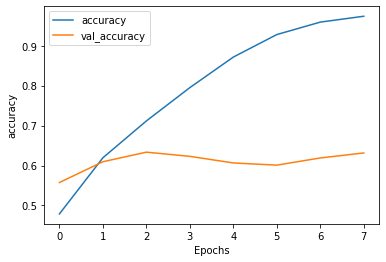

In [26]:
plot_graphs(history, 'accuracy')

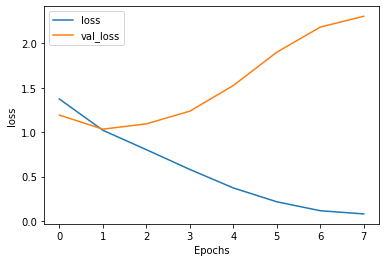

In [36]:
plot_graphs(history, 'loss')


In [28]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm,3)
        
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
cls_model.predict(test_movie_inputs)

array([[-5.181718  , -1.6064967 , -2.7068334 , ...,  6.9444013 ,
        -1.6309143 , -3.7577057 ],
       [-1.9206053 ,  2.0098882 , -3.1441529 , ..., -1.6479049 ,
         1.2217448 ,  2.2684705 ],
       [-4.374451  ,  1.828919  , -3.2682202 , ...,  5.7952237 ,
        -1.2395701 , -4.557975  ],
       ...,
       [-4.2376986 , -0.864794  ,  0.7534424 , ...,  1.5639521 ,
        -1.5936769 , -0.5462153 ],
       [-4.9006114 , -1.3577623 , -3.5070524 , ...,  8.858694  ,
        -1.7982383 , -2.3734915 ],
       [-5.0234523 ,  0.03386622, -1.2847917 , ...,  9.159009  ,
        -4.130806  , -2.8413324 ]], dtype=float32)

In [40]:
def create_sentiment_bert():
    cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=8)
    
    optimizer = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*2, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    cls_model.load_weights('./data_out/KOR/tf2_bert_naver_movie/weights.h5')


def create_sentiment_bert():
  # 버트 pretrained 모델 로드
  cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=8)
  
  # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')

  # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
  bert_outputs = bert_outputs[1]
  sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(bert_outputs)
  sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)

  cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
  return sentiment_model

In [41]:
import itertools

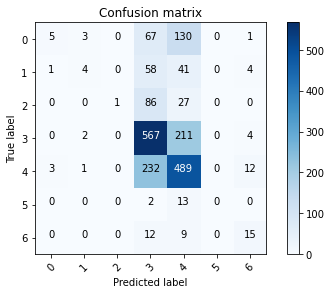

In [45]:
#검증 데이터 셋의 값을 예측
#loaded_model = cls_model()
cls_model.load_weights('./data_out/KOR/tf2_bert_naver_movie/weights.h5')

# 예측 클래스를 하나의 핫 벡터로 변환
Y_pred = cls_model.predict(test_movie_input_ids)

# 검증 관측치를 하나의 핫 벡터로 변환
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# 혼동 행렬 계산
confusion_mtx = confusion_matrix(test_data_labels, Y_pred_classes)

# 혼동 행렬 플로팅
plot_confusion_matrix(confusion_mtx, classes = range(7))

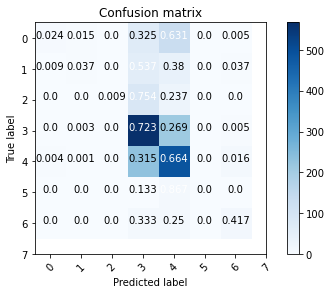

In [44]:
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# 혼동 행렬 계산
confusion_mtx = confusion_matrix(test_data_labels, Y_pred_classes)

# 혼동 행렬 플로팅
plot_confusion_matrix(confusion_mtx, classes = range(8),normalize = True)

In [ ]:
text_list = ['별난 재주 삼형제옛날 시골마을에 별난 재주 세 형제가 살았습니다', ' 눈이 밝은 맏이는 별별 것을 다 봅니다', ' 둘째는 천하장사 바윗돌도 번쩍번쩍', ' 개구쟁이 막내는 희한한 재주인데 매 맞는 재주입니다', ' 회초리로 때리면 간지럽다고 깔깔대고 절굿공이 내리치면 시원하다 깔깔댑니다', ' 그러던 어느 날 마을에 흉년이 들어 세 형제는 쫄쫄 굶고 나무뿌리 캐 먹으러 산 위로 올라갔습니다', ' “사람들 어찌 사나 어디 한 번 둘러볼까?” 눈 밝은 맏이가 어허 쯧쯧 혀를 찹니다', ' 논바닥이 쩌억 갈라지고 나무껍질이 홀라당 벗겨져 있었어요', ' 어른들은 굶어서 눈이 움푹 들어가고 아이들은 배고파 울고불고 소리칩니다', ' “으앙 배고파~”그중에서 어디서 밥을 짓나 하얀 연기가 모락모락 피어 오르고 있었어요', ' “마을 사또 사는 곳에 잔치가 열렸구나” 곡간에는 쌀가마니가 산처럼 쌓여 있고 대청마루 상 위에는 온갖 음식이 가득히 차려져 있었어요', ' 땀 흘려 거둔 곡식을 사또 혼자 차지한 것입니다', ' 세 형제는 그 모습을 보고 화가 나서 이리해 볼까, 저리해 볼까 고민을 했습니다', ' 밤은 깊어 가는데 둘째가 쌀가마를 이고 갑니다', ' 이 집 저 집 다니며 배불리 먹으라고 세 형제는 밤새도록 홍길동 노릇을 합니다', ' “야단났네! 야단났어! 곡간이 텅 비었네!” 자신의 곡간이 도둑이 든 것을 안 사또는 소리칩니다', ' 대신 집집마다 밥을 짓는 연기로 하얀 연기가 나오고 있었습니다', ' 욕심 많은 사또는 화가 났습니다', '온 마을 사람들이 끌려와서 성난 사또 눈길을 피해 벌벌 떨고 있는데 막내가 쏜살같이 달려와 “내가 바로 도둑이오!”라고 말을 합니다', ' 결국 막내는 형틀에 묶여 맨 궁둥이 까발리고 철썩 곤장을 맞습니다', ' 사람들은 무서워 벌벌 떠는데 “아 시원하다!”라고 막내는 좋아합니다', ' 한 사람씩 돌아가며 곤장 백 대 내리쳐도 졸린 듯 따분한 듯 막내는 하품을 합니다', ' 오히려 때리는 놈들이 힘들어합니다', ' 보다 못한 사또가 곤장을 칩니다', ' 약이 오른 사또는 날뛰다 뒤로 넘어져 버립니다', ' 결국 지친 사또는 세 형제를 집으로 돌려보내고, 사이 좋은 세 형제는 집으로 돌아갑니다', '신기한 재주를 가진 삼 형제는 자신들의 재주로 굶어가는 마을 사람들을 돕습니다', ' 자신의 장점과 재주가 무엇인지 알고 이를 좋은 곳에 쓴 삼 형제는 우리가 본받아야 할 부분입니다', ' 사또는 자신의 이익만 취하려고 하다가 결국 가지고 있던 것도 모두 잃은 케이스로 과도한 욕심은 오히려 독이 되는 경우가 있습니다', ' 그러므로 우리는 과도한 욕심을 부리지 않는 것은 물론 내가 갖고 있는 장점으로 남을 도울 수 있는 지혜를 기를 수 있는 노력이 필요합니다', '']

In [ ]:
def multi_book_evaluation_predict(text_list):
    for data in text_list :
        global tokenizer
        SEQ_LEN = 64
        tokens, masks, segments = [], [], []
        token = tokenizer.encode(data,
                                 max_length=SEQ_LEN,
                                 truncation=True,
                                 padding='max_length')
        num_zeros = token.count(0)
        
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN
        
        tokens.append(token)
        segments.append(segment)
        masks.append(mask)
        
        tokens = np.array(tokens)
        masks = np.array(masks)
        segments = np.array(segments)
        
        data_x =  [tokens, masks, segments]
        predict = loaded_model.predict(data_x)
        
        feeling = 0
        top_percent = 0
        
        for predic in predict:
            for i,pred in enumerate(predic):
                if top_percent < pred :
                    top_percent = pred
                    feeling = i
                    
        print(data)
        print(predic, feeling, top_percent)